# Engine Feature Importance

## Overview 
 
Howso Engine is a generalized Machine Learning (ML) and Artificial Intelligence platform that creates powerful decision-making models that are fully explainable, auditable, and editable. Howso Engine uses Instance-Based Machine Learning which stores instances, i.e., data points, in memory and makes predictions about new instances given their relationship to existing instances. This technology harnesses a fast spatial query system and techniques from information theory to enhance both performance and accuracy. 

In this notebook we will explore how to determine feature importance using Howso Engine.

In [1]:
import os

import numpy as np
import pandas as pd
import plotly.io as pio
import plotly.express as px
from pmlb import fetch_data

from howso.engine import Trainee
from howso.utilities import infer_feature_attributes

pio.renderers.default = os.getenv("HOWSO_RECIPE_RENDERER", "notebook")

# Section 1: Load, Train, Analyze

For questions about the specific steps of this section, please see the [basic workflow guide](https://docs.howso.com/user_guide/basics/basic_workflow.html).

### Step 1: Load Data

In [2]:
df = fetch_data('iris', local_cache_dir="../../data/iris")

# Infer feature attributes
features = infer_feature_attributes(df)

# Create the Trainee
t = Trainee(features=features)

### Step 2: Train, Analyze, and React

In [3]:
# Train
t.train(df)

# Targeted Analysis
t.analyze()

# Which features are important?

Feature importance is quantified by a combined analysis of how much each feature contributes to the prediction of another feature and whether that contribution improves or harms the accuracy of the prediction. For a given target (i.e., action, predicted) feature, Howso classifies each feature into one of four feature importance categories:

1. Red Flag Feature (RF): The feature contributes strongly to the prediction, but also adds uncertainty.

2. Important Feature (I): The feature contributes strongly to the prediction and reduces uncertainty.

3. Unimportant Feature (U): The feature contributes weakly to the prediction, but also adds uncertainty.

4. Tuning Feature (T): The feature contributes weakly to the prediction and reduces uncertainty.

Howso quantifies the contribution and uncertainty additions and reductions using each feature as the target feature in turn via following metrics:

Feature Contribution: the difference between a prediction of a target feature when each context feature is considered versus not considered during the prediction.

Mean Decrease in Accuracy (MDA): the mean decrease in accuracy of a target feature when each context feature is considered versus not considered during the prediction.

Howso summarizes the feature contribution and MDA results for each feature within matrices. To read a matrix, the label of each row (listed on the y-axis) indicates the target feature. Moving from left to right across each row of a matrix, the feature contribution or mda of each context feature for the target feature prediction can be identified. 

Note, the matrices also provide some insight into directional causality between features. This insight is useful for data scientists performing an exploratory data analysis (EDA).

   petal-width  sepal-length    target  sepal-width
0     0.401927        0.3607  0.412234     0.186329


   petal-length  petal-width    target  sepal-width
0      0.195352     0.173032  0.137752     0.114251


   petal-length  sepal-length    target  sepal-width
0      0.181542      0.145104  0.195373     0.064243


   petal-length  sepal-length  petal-width  sepal-width
0      0.208896      0.079856     0.227347     0.053877


   petal-length  sepal-length  petal-width    target
0      0.069016      0.097906     0.085151  0.046106


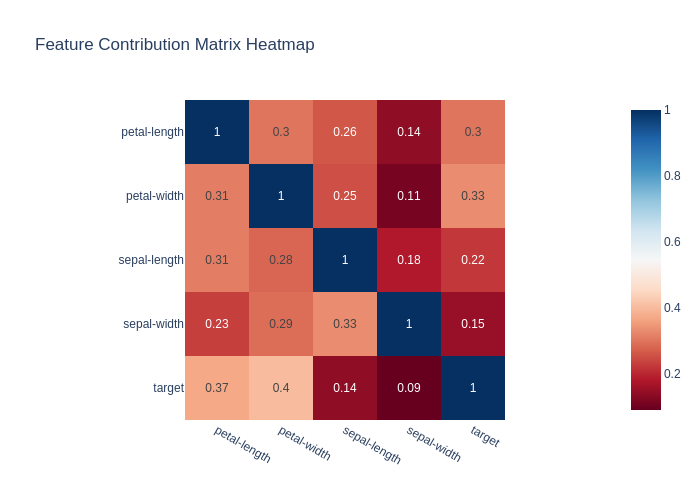

In [4]:
contrib_matrix = t.get_contribution_matrix()

# Plot the heatmap
fig = px.imshow(
    round(contrib_matrix, 2),
    color_continuous_scale='RdBu',
    text_auto=True,
    title = 'Feature Contribution Matrix Heatmap'
)
fig.show()

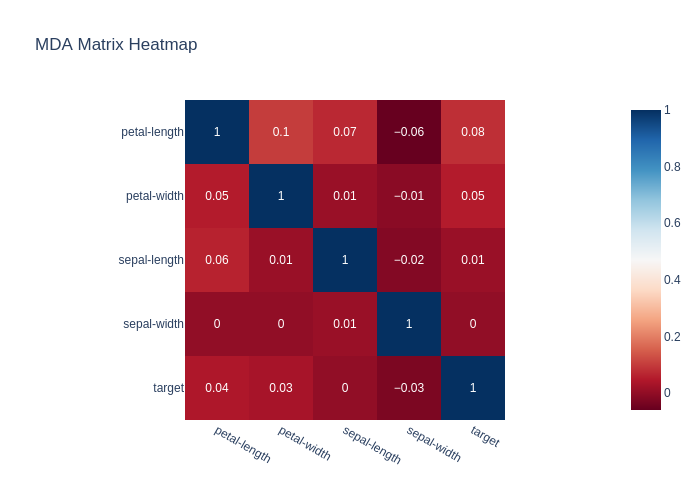

In [5]:
mda_matrix = t.get_mda_matrix()

# Plot the heatmap
fig = px.imshow(
    round(mda_matrix, 2),
    color_continuous_scale='RdBu',
    text_auto=True,
    title = 'MDA Matrix Heatmap'
)
fig.show()

# Difference Heatmap

By plotting the differences across diagonals in the heatmap, features that may have a directional or causual relationship can be revealed.

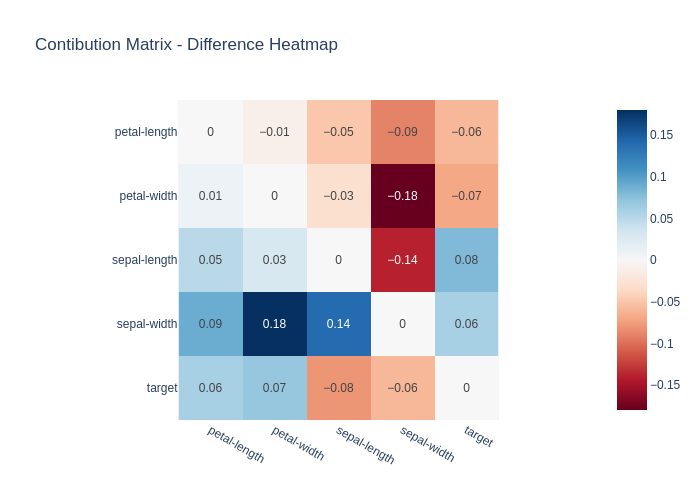

In [6]:
def diagonal_difference_df(df):
    """Calculates the differences of the diagonal values."""
    if df.shape[0] != df.shape[1]:
        raise ValueError("DataFrame must be square")
    return df - df.transpose()

diff_contrib_matrix = diagonal_difference_df(contrib_matrix)

# Plot the heatmap
fig = px.imshow(
    round(diff_contrib_matrix, 2),
    color_continuous_scale='RdBu',
    text_auto=True,
    title = 'Contibution Matrix - Difference Heatmap'
)
fig.show()

# Difference categories

We can group these differences into categories based on a custom criteria. In this example below, we compare each value with the mean of the rows.

By categorizing these features, we can easily digest the relative importance of these features and gain insights into the characteristics of the relationships within the data.

In [7]:
# Example helper functions group categories

def check_quantile(row):
    """Compare each element to the mean and returns 'large' or 'small'."""
    if row.empty:
        return pd.Series(["small"] * len(row), index=row.index)
    mean = row.mean()
    return row.apply(lambda x: "large" if x > mean else "small")

def group_elements(x, y):
    """Groups the quantiles into categories."""
    if x == 'large' and y == 'large':
        return 'Important'
    elif x == 'large' and y == 'small':
        return 'Red Flag'
    elif x == 'small' and y == 'large':
        return 'Red Flag'
    elif x == 'small' and y == 'small':
        return 'Unimportant'
    else:
        return 'Tuning'

In [8]:
# Replace diagonals with Nan so they are not included in calculations
np.fill_diagonal(contrib_matrix.values, np.nan)
np.fill_diagonal(mda_matrix.values, np.nan)

contrib_matrix_cat = contrib_matrix.apply(check_quantile, axis=1)
mda_matrix_cat = mda_matrix.apply(check_quantile, axis=1)

# Create a new dataframe by comparing df1 and df2 element-wise
comparison = pd.DataFrame(index=contrib_matrix_cat.index, columns=contrib_matrix_cat.columns)
for col in contrib_matrix_cat.columns:
    comparison[col] = np.vectorize(group_elements)(contrib_matrix_cat[col], mda_matrix_cat[col])
comparison

,petal-length,petal-width,sepal-length,sepal-width,target
petal-length,Unimportant,Important,Important,Unimportant,Important
petal-width,Important,Unimportant,Unimportant,Unimportant,Important
sepal-length,Important,Red Flag,Unimportant,Unimportant,Unimportant
sepal-width,Unimportant,Red Flag,Important,Unimportant,Unimportant
target,Important,Important,Unimportant,Unimportant,Unimportant


We recommend modifying the threshold for classifying these features. This example classifies features based on the mean for simplicity, however a more stratified classification may provide better results.